# 0. Propuesta

El ejercicio que se muestra a continuación trata de encontrar un modelo de regresión multiple que sea capaz predecir con cierta precisión el precio de unas pólizas de seguros de vida, acorde a una serie de características y hábitos del sujeto que lo contrata. 

La idea es encontrar el mejor modelo, escogiendo qué variables independientes son las que contribuyen más a la predicción y cuales pueden añdir ruido, si este fuere el caso. Los datos se han obtenido de la web Kaggle a través de su api como sigue:

```
kaggle kernels output brandonyongys/insurance-charges -p insurance.csv
```

Y están disponibles para bajar aquí: https://www.kaggle.com/code/brandonyongys/insurance-charges/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. Lectura y descripción de los datos

In [2]:
data_insurance = pd.read_csv("insurance.csv")
data_insurance.info()
data_insurance.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [3]:
# No parece haber valores nulos. Una comprobación rápida
try:
    assert sum(data_insurance.isnull().sum()) == 0
except AssertionError:
    print("Existen valores nulos en el datframe")
else:
    print("No se han detectado valores nulos en el dataframe")



No se han detectado valores nulos en el dataframe


# 2. Exploración de las correlaciones entre las variable dependiente y las independiente

* **Variable dependiente**: *charges*. El precio que las aseguradaras cargan a las personas que contratan el seguro.
* **Variable independiente**: *age, sex, bmi, children, smoker y region*. Son características vitales de la persona que contibuyen la ecuación de evaluación por parte de las aseguradoras. También hay características de otro tipo como la región donde viven o los hábitos que tienen, como fumar.


## 2.1 Relación entre fumadores, bmi y precio de la póliza


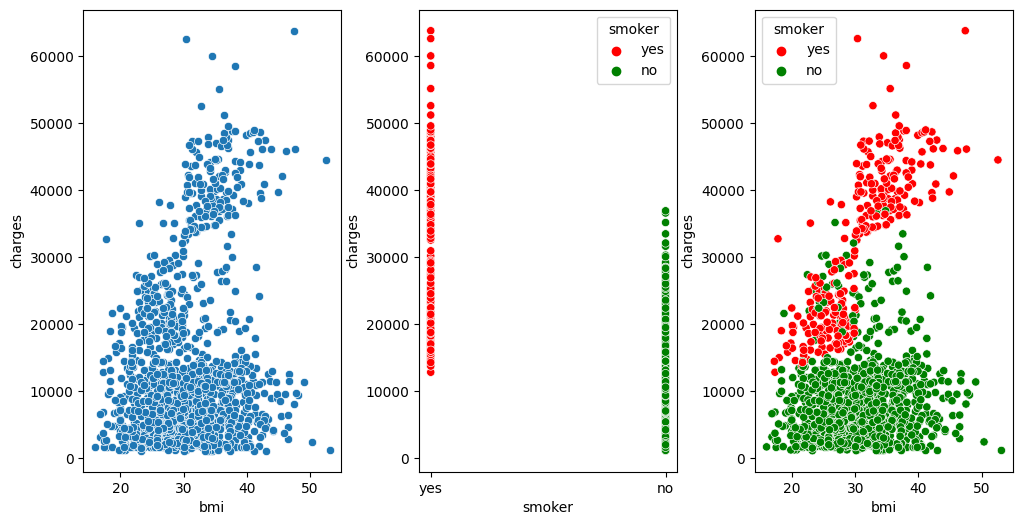

In [4]:
# Visualizamos dos gráficos paralelos de bmi y smokers
_, ax =plt.subplots(nrows=1, ncols=3, figsize=(12,6))
sns.scatterplot(data=data_insurance, x = "bmi", y="charges", ax=ax[0])
sns.scatterplot(data=data_insurance, x = "smoker", y="charges", palette=['red','green'], hue='smoker', ax=ax[1])
sns.scatterplot(data=data_insurance, x = "bmi", y="charges", palette=['red','green'], hue='smoker', ax=ax[2])
plt.subplots_adjust(wspace = 0.3)

**Conclusion 1**: Parece ser que que los fumadores están más correlacionados con el precio de las pólizas, ya que aquellos que fuman están en un intervalo de precios mayor. Sin embargo, esto no ocurre para el bmi. Por ejemplo, hay casos de personas con un bmi entre 20 y 40 que tienen asociados pólizas o muy baja o muy altas, pero esto tiene más que ver con si son fumadores o no, parece ser.

## 2.2 Relación entre el lugar de residencia y el precio de la póliza


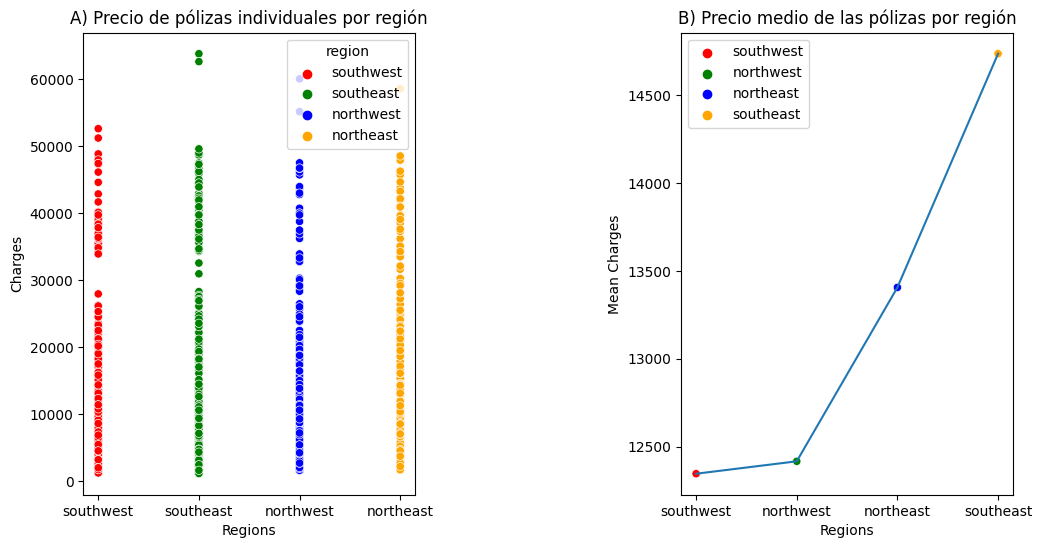

In [5]:
'''
Grafico A: plotea los valores de las pólizas por cada individuo y cada región
Grafico B: plotea los valores medios las pólizas por cada región
'''
len(set(data_insurance.region))
region_df = pd.DataFrame(data = {'region': data_insurance.region, 'charges': data_insurance.charges})
region_means = region_df.groupby(region_df.region).mean().reset_index().sort_values(by='charges')

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(data=region_df, x = "region", y="charges", palette=['red','green','blue', 'orange'], hue='region', ax=ax[0]).set(title = "A) Precio de pólizas individuales por región")
sns.scatterplot(data=region_means, x = "region", y="charges", palette=['red','green','blue', 'orange'], hue='region', ax=ax[1]).set(title = "B) Precio medio de las pólizas por región")
sns.lineplot(data=region_means, x="region", y="charges", ax=ax[1])
ax[0].set_xlabel('Regions')
ax[0].set_ylabel('Charges')
ax[1].set_xlabel('Regions')
ax[1].set_ylabel('Mean Charges')
plt.subplots_adjust(wspace = 0.8)



**Conclusion 2**: La región de residencia tampoco parece afectar al precio de la póliza de seguro, si bien hay ligeras diferencias entre las áreas, siendo southwest y southeast las regiones con menor y mayores cargos, respectivamente.

## 2.3 Relación entre fumadores, edad, hijos y el precio de la póliza


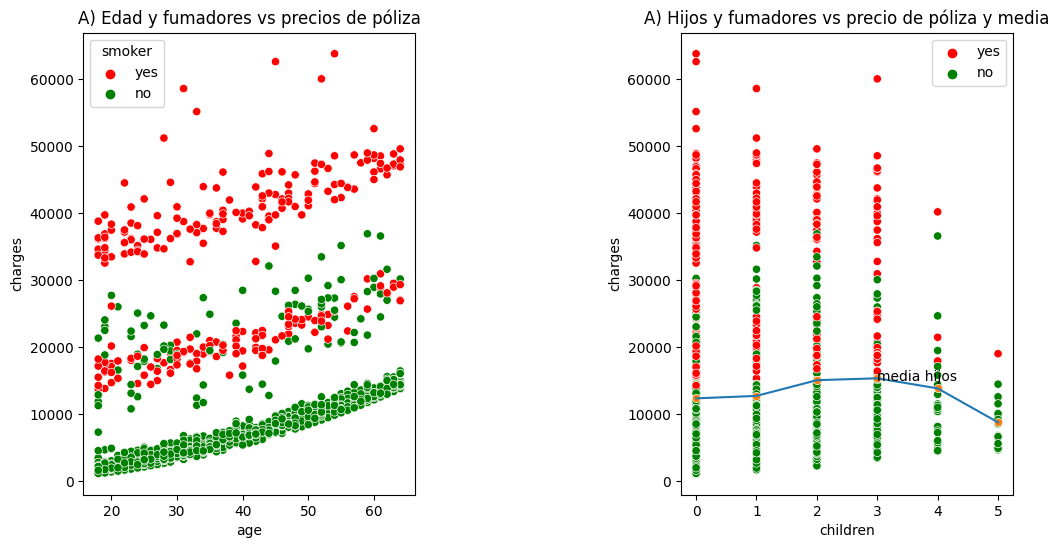

In [6]:
'''
Grafico A: plotea los valores de las pólizas por edad y fumadores
Grafico B: plotea los valores medios las pólizas por hijos y sexo, así como la media por hijos
'''
children_df = pd.DataFrame(data = {'children': data_insurance.children, 'charges': data_insurance.charges})
children_means = region_df.groupby(children_df.children).mean(numeric_only=True).reset_index().sort_values(by='charges')

_, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x = "age", y = "charges", data = data_insurance, palette=['red','green'], hue='smoker', ax=ax[0]).set(title= "A) Edad y fumadores vs precios de póliza")
sns.scatterplot(x = "children", y = "charges", data = data_insurance, palette=['red','green'], hue='smoker', ax=ax[1]).set(title= "A) Hijos y fumadores vs precio de póliza y media")
sns.scatterplot(x = "children", y = "charges", data = children_means, ax=ax[1])
sns.lineplot(data=children_means, x="children", y="charges", ax=ax[1])
plt.text(3,15000,"media hijos")
plt.subplots_adjust(wspace = 0.8)

**Conclusion 3**: Parece ser que la edad tiene una tendencia a que las pólizas sean más alta pero es más bien gradual. Sin embargo, cuando hablamos de fumadores (figura A), el salto es cualitativo. De hecho, un tanto por ciento muy alto de fumadores está por encima de los no fumadores.

## 2.4 Relación entre bmi, sexo y precio de la póliza

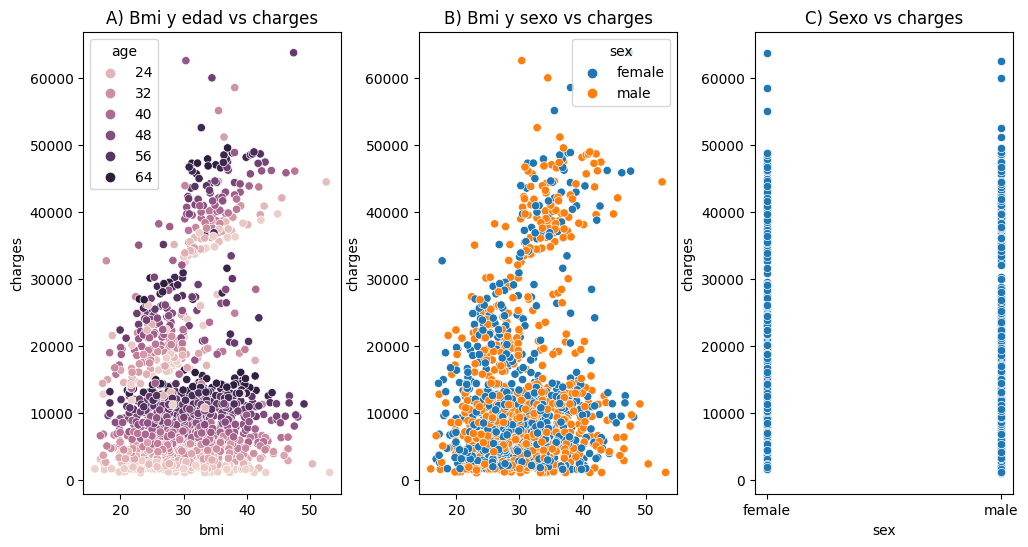

In [7]:
_, ax =plt.subplots(nrows=1, ncols=3, figsize=(12,6))
sns.scatterplot(data=data_insurance, x = "bmi", y="charges", hue='age', ax=ax[0]).set(title="A) Bmi y edad vs charges")
sns.scatterplot(data=data_insurance, x = "bmi", y="charges", hue='sex', ax=ax[1]).set(title="B) Bmi y sexo vs charges")
sns.scatterplot(data=data_insurance, x = "sex", y="charges", ax=ax[2]).set(title="C) Sexo vs charges")
plt.subplots_adjust(wspace = 0.3)

**Conclusion 4**: No hay una inferencia tan clara cuando se plotea el bmi y la edad como ocurre cuando éste se plotea con el hecho de ser fumador o no. Aunque sí que se aprecia que a mayor edad, las pólizas son ligeramente más altas.

# 3. Modelo de regresión multiple con diferentes características

Hemos visto que no todas las variables independientes parecen contribuir lo mismo a los precios de las pólizas, de forma que el ser fumador o no y la edad parecen ser las variables más decisivas, mientras que el bmi, los hijos y el lugar de residencia son bastante más inócuas.

La idea es construir tres modelos de regresión múltiple como sigue:

* **Primer modelo**: será construido con las variables indpendientes bmi y smoker. 
* **Segundo modelo**: será construido con las variables indpendientes bmi y age. 
* **Tercer modelo**: será construido con las variables indpendientes bmi, smoker y age.
* **Cuarto modelo**: será construido todas las variables independientes.

La razón de usar BMI is porque es una variable discreta no categórica. Una vez construidos los modelos, calcularemos sus respectivas R y veremos cuál de ellos se ajusta más y tiene mayor capacidad de predicción, es decir, cuál se acerca más a 1. 

## 3.1 Prepara el dataframe (variables categóricas a numéricas)

In [8]:
cat_variables = ['sex', 'smoker', 'region']
clean_data = data_insurance.copy()
for var in cat_variables:
    clean_data[var] = data_insurance[var].astype('category').cat.codes
    assert [isinstance(x, int) for x in set(data_insurance[var])]  # nos aseguramos que todos los varoes de cada categoria son numericos

clean_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


## 3.2 Cálculo de los cuatro modelos de regresión y R^2

In [9]:
features = [('bmi', 'smoker'), ('bmi', 'age'), ('bmi', 'smoker', 'age'), tuple(x for x in clean_data.columns if x != 'charges')]
features

[('bmi', 'smoker'),
 ('bmi', 'age'),
 ('bmi', 'smoker', 'age'),
 ('age', 'sex', 'bmi', 'children', 'smoker', 'region')]

In [10]:
y = data_insurance.charges
test_size = 0.3 # 30% of the dataset for testing
data_sets = []
models = {}
adjusted_r_scores = []
model_types = ('bmi_smoker', 'bmi_age', 'bmi_smoker_age', 'all')
y_test_real = []
y_test_predicts = []

# Crea los distintos training y test data sets para cada modelo
for ind_features in features:
    x = clean_data.loc[:, ind_features]
    data_sets.append(train_test_split(x, y, test_size=test_size))

# Crea los tres modelos de regresión y los r^2 para cada modelo
for label, data in zip(model_types, data_sets):
    reg_model = LinearRegression()
    X_train, X_test, y_train, y_test = data
    # --> genera el modelo
    reg_model.fit (X_train, y_train)
    # --> ejecuta el modelo para obetener los valores a predecir
    y_predict = reg_model.predict(X_test)
    # --> obtines los r^2 y el modelo creado
    models[label] = reg_model
    adjusted_r_scores.append(r2_score(y_test, y_predict))
    y_test_real.append(y_test)
    y_test_predicts.append(y_predict)
    
models
adjusted_r_scores
    

[0.6374868323294439,
 0.13113809937816623,
 0.7260087684592791,
 0.7445100222862758]

Text(0, 0.5, 'R^2')

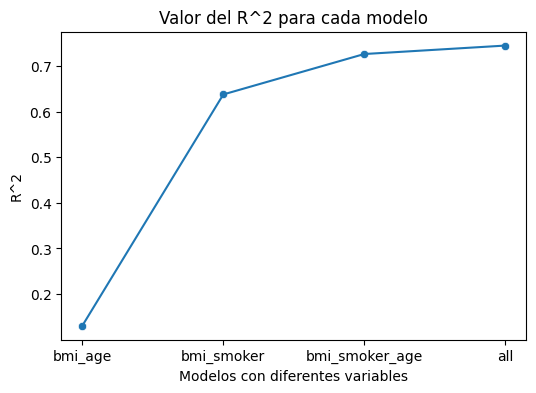

In [11]:
# Ploteamos el valor sde los R^2 para los diferentes modelos en orden ascendente
fig,ax = plt.subplots(figsize=(6, 4))
r2_df = pd.DataFrame(data={'models': model_types, 'r2': adjusted_r_scores})
r2_df = r2_df.sort_values(by='r2')
sns.scatterplot(data=r2_df, x = "models", y="r2", ax=ax).set(title="Valor del R^2 para cada modelo")
sns.lineplot(data=r2_df, x="models", y="r2", ax=ax)
ax.set_xlabel('Modelos con diferentes variables')
ax.set_ylabel('R^2')

**Conclusión**: parece ser que la R^2 se ajusta más en el modelo que sólo tiene como variables independientes *bmi*, *smoker* y *age*. Cuando se le añaden o restan variables independientes, el modelo empeora. Nótese el salto de calidad cuando aparece la variable smoker, es decir, las pólizas de seguro aumentan mucho cuando el sujeto que la contrata es fumador

## 3.3 Visualización de las predicciones

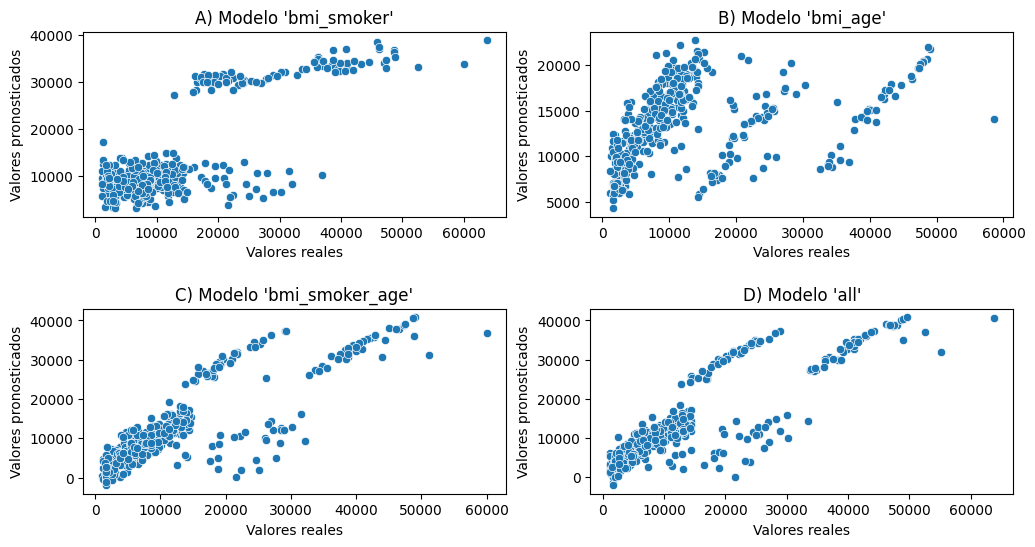

In [12]:
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(12,6))
x_label = "Valores reales"
y_label = "Valores pronosticados"

# simulación de índices de array bidemensional para acceder al objeto ax
ax_rows = [0, 0, 1, 1]
ax_columns = [0, 1, 0, 1]
letras = ['A', 'B', 'C', 'D']

# loop en paralelo sobre varias estructuras
for i, j, letra, model_name, x, y in zip(ax_rows, ax_columns, letras, model_types, y_test_real, y_test_predicts):
    ax[i][j].set_xlabel(x_label)
    ax[i][j].set_ylabel(y_label)
    title = f"{letra}) Modelo '{model_name}'"
    results_df = pd.DataFrame(data= {'real': x, 'pronosticado': y})
    sns.scatterplot(data=results_df, x = "real", y="pronosticado", ax=ax[i][j]).set(title=title)
    

plt.subplots_adjust(hspace = 0.5)

**Conclusión**: Parece claro que visualmente el peor modelo de todos es el del gráfico B formado por las variables independientes *bmi* y *age*, donde los valores pronosticados están muy dispersos formando varias bandas. El modelo del gráfico B formado por *bmi* y *smoker* mejora las previsiones sustancialmente, donde los valores pronesticados tienden a agruparse linealmente. Finalmente los modelos C y D mejoran todavía más, aunque en D se observa que cuando se utilizan todas las variables independientes, los valores pronosticados tienden a dispersarse un poco más, es decir, parecen no estar tan alineados como en C, aunque la percepción es realmente sutil. Por tanto la visualización de las predicciones parece coincider con la correlación R^2.

Finalmente las variables *children*, *region* y *sex* no parecen contribuir, más bien añadir ruido al modelo. Para una conclusión todavía más certera habría que hacer una combinación de todas las variables posibles y crear los modelos correspondientes. Sin embargo, la exploración visual inicial nos daba bastantes pistas de que dichas variables eran más bien inocuas.